In [286]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import matplotlib.style as style; style.use('fivethirtyeight')
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.sparse.linalg import svds
import gc
%matplotlib inline

# For Sklearn NearestNeighbor based recommendation
from sklearn.metrics import pairwise_distances, mean_squared_error
from scipy.spatial.distance import correlation, cosine
from scipy.sparse import csr_matrix
import sklearn.metrics as metrics
from math import sqrt


# Display settings
pd.options.display.max_rows = 999
pd.options.display.max_columns = 20
pd.options.display.float_format = "{:.2f}".format

# Suppress warnings
import warnings; warnings.filterwarnings('ignore')

In [25]:
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

In [3]:
ratings_data = pd.read_csv("ratings_Electronics.csv",header=None)  
ratings_data.head() 

,0,1,2,3
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [4]:
ratings_data.columns = ['User_id','Product_id','Ratings','TimeStamp']

In [6]:
ratings_data.head()

,User_id,Product_id,Ratings,TimeStamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [8]:
ratings_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
User_id       object
Product_id    object
Ratings       float64
TimeStamp     int64
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [7]:
ratings_data['Ratings'].value_counts()

5.0    4347541
4.0    1485781
1.0     901765
3.0     633073
2.0     456322
Name: Ratings, dtype: int64

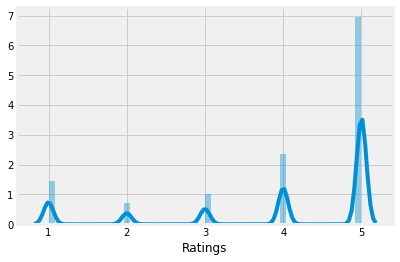

In [288]:
sns.distplot(ratings_data['Ratings'])

In [268]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [21]:
ratings_data.describe()

,Ratings,TimeStamp
count,7824482.00,7824482.00
mean,4.01,1338178197.27
std,1.38,69004257.79
min,1.00,912729600.00
25%,3.00,1315353600.00
50%,5.00,1361059200.00
75%,5.00,1386115200.00
max,5.00,1406073600.00


In [245]:
#pd.reset_option('display.float_format')

In [22]:
ratings_data.isna().apply(pd.value_counts)

,User_id,Product_id,Ratings,TimeStamp
False,7824482,7824482,7824482,7824482


In [30]:
print(pysqldf("select count(distinct Product_id),count(distinct User_id) from ratings_data;"))

   count(distinct Product_id)  count(distinct User_id)
0                      476002                  4201696


In [33]:
print('Count of unique Users    :', ratings_data.User_id.nunique())
print('Count of unique Products :', ratings_data.Product_id.nunique())

Count of unique Users    : 4201696
Count of unique Products : 476002


- Looks like pandasql library it little slower.

In [36]:
print('Possible combination of ratings for given number of products is: ', ratings_data.User_id.nunique() * ratings_data.Product_id.nunique())

Possible combination of ratings for given number of products is:  2000015699392


In [42]:
per_user_rating = ratings_data.User_id.value_counts().rename_axis('User_id')

In [43]:
per_user_rating.head()

User_id
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
Name: User_id, dtype: int64

In [70]:
df = ratings_data[ratings_data.User_id.isin(per_user_rating[per_user_rating > 49].index)]

In [73]:
np.shape(df)

(125871, 4)

In [75]:
df.head()

,User_id,Product_id,Ratings,TimeStamp
94,A3BY5KCNQZXV5U,0594451647,5.00,1390176000
118,AT09WGFUM934H,0594481813,3.00,1377907200
177,A32HSNCNPRUMTR,0970407998,1.00,1319673600
178,A17HMM1M7T9PJ1,0970407998,4.00,1281744000
492,A3CLWR1UUZT6TG,0972683275,5.00,1373587200


In [74]:
print('Count of unique Users of subset   :', df.User_id.nunique())
print('Count of unique Products of subset:', df.Product_id.nunique())

Count of unique Users of subset   : 1540
Count of unique Products of subset: 48190


### Split the Data

In [83]:
df = df.drop(columns = "TimeStamp")
train_data, test_data = train_test_split(df, test_size = 0.30, random_state = 9)
display(train_data.shape, test_data.shape)

(88109, 3)

(37762, 3)

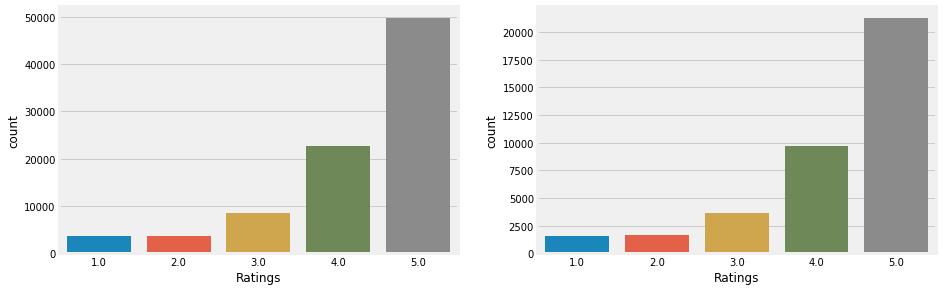

In [105]:
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
sns.countplot(train_data['Ratings'])
plt.subplot(2,2,2)
sns.countplot(test_data['Ratings'])
plt.show()

### Popularity Based Recommender System

##### For popularity based, we will extract products rated min X amount of times and users who have rated Y number of products. Keeping such a threshold will help us filter genuine users and also help us identify popular products based on mean rating. 

In [186]:
per_product_rating = df_popular.Product_id.value_counts().rename_axis('Product_id')

In [189]:
per_product_rating.head()

Product_id
B0088CJT4U    206
B003ES5ZUU    184
B000N99BBC    167
B007WTAJTO    164
B00829TIEK    149
Name: Product_id, dtype: int64

In [136]:
df_popular = ratings_data[ratings_data.User_id.isin(per_user_rating[per_user_rating > 49].index)]

#### List of products recommended sorted by mean of ratings and count of number of ratings. 

In [191]:
df_popular.groupby('Product_id')['Ratings'].mean().head()  

Product_id
0594451647   5.00
0594481813   3.00
0970407998   2.50
0972683275   4.75
1400501466   3.33
Name: Ratings, dtype: float64

#### List of products with highest mean - But count is not taken into consideration ( so a product might be rated just once also )

In [192]:
df_popular.groupby('Product_id')['Ratings'].mean().sort_values(ascending=False).head()  

Product_id
B00LKG1MC8   5.00
B002QUZM3M   5.00
B002QWNZHU   5.00
B002QXZPFE   5.00
B002R0DWNS   5.00
Name: Ratings, dtype: float64

#### List of products who got maximum number of ratings but here the mean score of rating is not taken into consideration

In [193]:
df_popular.groupby('Product_id')['Ratings'].count().sort_values(ascending=False).head()  

Product_id
B0088CJT4U    206
B003ES5ZUU    184
B000N99BBC    167
B007WTAJTO    164
B00829TIEK    149
Name: Ratings, dtype: int64

In [194]:
popularity_recommendations = (pysqldf("select Product_id, sum(Ratings)/count(Ratings) as score, count(Ratings) as Count from df_popular group by Product_id order by score desc, Count desc limit 5;"))
popularity_recommendations.head()

,Product_id,score,Count
0,B000FQ2JLW,5.00,19
1,B00ISFNSBW,5.00,18
2,B000IJY8DS,5.00,17
3,B001TH7GUA,5.00,17
4,B00HZWJGS8,5.00,17


In [198]:
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['User_id'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [199]:
find_recommendation_for = [130,230]
for i in find_recommendation_for:
    print("The list of recommendations for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n") 

The list of recommendations for the userId: 130

   User_id  Product_id  score  Count  userId
0      130  B000FQ2JLW   5.00     19     230
1      130  B00ISFNSBW   5.00     18     230
2      130  B000IJY8DS   5.00     17     230
3      130  B001TH7GUA   5.00     17     230
4      130  B00HZWJGS8   5.00     17     230


The list of recommendations for the userId: 230

   User_id  Product_id  score  Count  userId
0      230  B000FQ2JLW   5.00     19     230
1      230  B00ISFNSBW   5.00     18     230
2      230  B000IJY8DS   5.00     17     230
3      230  B001TH7GUA   5.00     17     230
4      230  B00HZWJGS8   5.00     17     230




### So here we have recommended top 5 products with respect to popularity based system.
#### Popularity based systems are not used personalized

# Building collaborative filtering recommendation system

In [208]:
df_cf = ratings_data[ratings_data.User_id.isin(per_user_rating[per_user_rating > 49].index)]

In [211]:
df_cf = df_cf.drop(columns = "TimeStamp")

#### Item Based CF

In [282]:
ratings_item = df_cf.pivot(index = 'User_id', columns = 'Product_id', values = 'Ratings').fillna(0)
ratings_item.head()

Product_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
User_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
A100WO06OQR8BQ,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
A105S56ODHGJEK,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
A105TOJ6LTVMBG,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
A10AFVU66A79Y1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [283]:
# Singular Value Decomposition
U, sigma, Vt = svds(ratings_item, k = 10)
sigma = np.diag(sigma)

all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = ratings_item.columns, index = ratings_item.index) #predicted ratings
preds_df.head()

Product_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
User_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.00,0.00,0.00,0.01,0.00,0.00,0.01,0.00,0.01,0.00,...,0.00,0.04,0.00,0.06,-0.00,0.01,0.00,0.13,0.06,0.02
A100WO06OQR8BQ,0.00,0.00,0.01,0.02,0.01,0.00,0.01,0.00,-0.00,0.00,...,0.00,0.03,0.00,0.00,-0.00,-0.00,0.00,-0.04,-0.01,0.00
A105S56ODHGJEK,-0.00,-0.00,0.00,0.02,0.01,-0.00,0.01,0.00,-0.01,-0.00,...,-0.00,0.01,-0.00,-0.02,0.02,-0.00,-0.00,-0.00,-0.01,-0.00
A105TOJ6LTVMBG,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.01,0.00,...,0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,-0.02,-0.01,0.00
A10AFVU66A79Y1,0.00,0.00,0.00,0.01,0.00,0.00,0.01,0.00,-0.00,0.00,...,0.00,-0.00,-0.00,-0.03,0.00,-0.00,0.00,-0.05,-0.02,-0.00


In [284]:
# Recommend products with highest predicted ratings
print('Creating a function to recommend products with highest predicted ratings')
def recommend_items(user_id, ratings_item, preds_df, num_recommendations = 5):
    try:
        print('User has already rated products (from data in training set): {}'.format(train_data.loc[(train_data['UserID'] == user_id), 'ProductID'].nunique()))
        print('Top 5 products from what\'s already being rated: {}'.format(list(train_data[(train_data['UserID'] == user_id)].sort_values(by = 'Rating', ascending = False).head(5)['ProductID'])))
    except:
      print('There\'s no data for the selected user in training set')
    sorted_user_ratings = ratings_item.loc[user_id].sort_values(ascending = False)
    
    sorted_user_predictions = preds_df.loc[user_id].sort_values(ascending = False)
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis = 1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]
    temp = temp.sort_values('user_predictions', ascending = False)
    print('\nTop 5 recommendations for the user based on item-based collaborative filtering method')
    display(temp.head(num_recommendations))
    return temp.head(num_recommendations).index.tolist()

Creating a function to recommend products with highest predicted ratings


In [285]:
result = {}

user_id = "A100WO06OQR8BQ"
print(f'\nMake recommendation for the user id selected from the testset = "{user_id}"')
result[user_id] = recommend_items(user_id, ratings_item, preds_df)

user_id = "A10AFVU66A79Y1"
print(f'\n\nMake recommendation for the user id selected from the testset = "{user_id}"')
result[user_id] = recommend_items(user_id, ratings_item, preds_df)


Make recommendation for the user id selected from the testset = "A100WO06OQR8BQ"
There's no data for the selected user in training set

Top 5 recommendations for the user based on item-based collaborative filtering method


,user_ratings,user_predictions
Recommended Items,,
B000N99BBC,0.00,1.46
B00829TIEK,0.00,1.27
B004CLYEDC,0.00,1.25
B00829THK0,0.00,1.10
B0034CL2ZI,0.00,0.80




Make recommendation for the user id selected from the testset = "A10AFVU66A79Y1"
There's no data for the selected user in training set

Top 5 recommendations for the user based on item-based collaborative filtering method


,user_ratings,user_predictions
Recommended Items,,
B0088CJT4U,0.00,0.90
B000N99BBC,0.00,0.75
B00829TIEK,0.00,0.72
B008DWCRQW,0.00,0.66
B004CLYEDC,0.00,0.65


In [253]:
rmse_df = pd.concat([ratings_item.mean(), preds_df.mean()], axis = 1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
RMSE = round((((rmse_df['Avg_actual_ratings'] - rmse_df['Avg_predicted_ratings']) ** 2).mean() ** 0.5), 4)
print('RMSE OF ITEM BASED COLLABORATIVE FILTERING USING MATRIX FACTORIZATION METHOD (SVD): {}'.format(RMSE))

RMSE OF ITEM BASED COLLABORATIVE FILTERING USING MATRIX FACTORIZATION METHOD (SVD): 0.0033


In [254]:
electronics_df_CF = pd.concat([train_data, test_data]).reset_index()
electronics_df_CF.head()

,index,User_id,Product_id,Ratings
0,2283146,A2WLNSZ9U0T1S3,B001SEQN3U,4
1,6943885,A2XIOXRRYX0KZY,B00AR95FOU,4
2,6083141,A3AZI828WJN1CD,B0085YTCYS,3
3,6105233,AMKNPIDFLRFMP,B0088CJT4U,5
4,974734,A5A4374R8I7NB,B000GLIIFW,4


## Method 2

In [274]:
final_ratings_matrix = df_cf.pivot(index = 'User_id', columns ='Product_id', values = 'Ratings').fillna(0)

In [256]:
# User based CF

pivot_df = electronics_df_CF.pivot(index = 'User_id', columns ='Product_id', values = 'Ratings').fillna(0)
pivot_df.head()

Product_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
User_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A100WO06OQR8BQ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A105S56ODHGJEK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A105TOJ6LTVMBG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A10AFVU66A79Y1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [257]:
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

Product_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8,user_index
User_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A100WO06OQR8BQ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
A105S56ODHGJEK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
A105TOJ6LTVMBG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
A10AFVU66A79Y1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


In [258]:
pivot_df.set_index(['user_index'], inplace=True)
# Actual ratings given by users
pivot_df.head()

Product_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_index,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [259]:
# Using SVD again
U, sigma, Vt = svds(pivot_df, k = 10)

In [260]:
print('Left singular matrix: \n',U)

Left singular matrix: 
 [[-0.00899214 -0.00598943 -0.01133778 ... -0.02098223  0.03450332
  -0.02112691]
 [-0.0078874  -0.01984352 -0.00397075 ... -0.01076097 -0.02009915
  -0.03863719]
 [-0.00060497  0.00421198 -0.00381018 ...  0.02924332 -0.03319807
  -0.03354122]
 ...
 [ 0.0069631  -0.0863053   0.02353607 ... -0.01332978  0.1613707
  -0.05949368]
 [ 0.00238725 -0.0032176  -0.00374118 ... -0.00677598 -0.00445708
  -0.01348483]
 [ 0.00097386 -0.00410379  0.002161   ... -0.01215862  0.00249329
  -0.00561029]]


In [261]:
print('Sigma: \n',sigma)

Sigma: 
 [ 87.43474122  88.68897677  91.15027972  92.15989229  95.03789667
  98.21626326 100.38232831 107.7090351  119.69501814 182.29276718]


In [263]:
# WE require a diagonal metric - sigma
# Construct diagonal array in SVD
sigma = np.diag(sigma)
print('Diagonal matrix: \n',sigma)

Diagonal matrix: 
 [[ 87.43474122   0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.          88.68897677   0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.          91.15027972   0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.          92.15989229   0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.          95.03789667
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
   98.21626326   0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.         100.38232831   0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.      

In [264]:
#Predicted ratings
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
# Convert predicted ratings to dataframe
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

Product_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,-0,0,...,0,0,0,0,-0,-0,0,-0,-0,0
2,-0,-0,0,0,0,-0,0,0,-0,-0,...,-0,0,-0,-0,0,-0,-0,-0,-0,-0
3,0,0,0,0,0,0,0,0,0,0,...,0,-0,0,-0,-0,0,0,-0,-0,0
4,0,0,0,0,0,0,0,0,-0,0,...,0,-0,-0,-0,0,-0,0,-0,-0,-0


In [265]:
def recommend_items(userID, pivot_df, preds_df, num_recommendations):
    # index starts at 0  
    user_idx = userID-1 
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [270]:
userID = 6
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 6):

                   user_ratings  user_predictions
Recommended Items                                
B00829TIEK                 0.00              1.35
B008DWCRQW                 0.00              1.19
B004CLYEDC                 0.00              1.02
B002R5AM7C                 0.00              0.93
B00829THK0                 0.00              0.93


In [271]:
userID = 8
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 8):

                   user_ratings  user_predictions
Recommended Items                                
B003ES5ZUU                 0.00              1.92
B002V88HFE                 0.00              1.43
B002WE6D44                 0.00              1.26
B001TH7GUU                 0.00              1.25
B005HMKKH4                 0.00              0.98


- Since, it is a Collaborative recommender model, so, all the three users are given different recommendations based on users past behaviour.

In [275]:
# Evaluating
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(48190, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
Product_id,,,
0594451647,0.00,0.00,0
0594481813,0.00,0.00,1
0970407998,0.00,0.00,2
0972683275,0.01,0.01,3
1400501466,0.01,0.00,4


In [276]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.0033 



In [277]:
# Enter 'userID' and 'num_recommendations' for the user #
userID = 9
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 9):

                   user_ratings  user_predictions
Recommended Items                                
B009NHWVIA                 0.00              0.99
B004CLYEFK                 0.00              0.97
B007WTAJTO                 0.00              0.96
B0088CJT4U                 0.00              0.92
B0097CXWUW                 0.00              0.80


## Conclusion

- Non-personalized based recommendation system (such as popularity) is generated by averaging the recommendations for all the users. Here we recommended top 5 products to the users. Also saw how we can make use of count to suggest popular products to the users and hybrid popularity based recommender based on a combination of mean and count.
- Collaborative-based recommendations are personalized since the rating "prediction" differs depending on the target user and it is based on

- User-to-user: ratings for a given product expressed by users that are similar to the active user.
- Item-to-item: weighted average of the ratings of the active users for the similar items

- Items with lots of history gets recommended a lot, while those without never make it into the recommendation engine

- We have Evaluated the models and producted the RMSE 0.0033 value and given top 5 recommendations 